In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

In [2]:
PATH = '/home/disij/projects/acdc/data/'

In [3]:
# load BMMC data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']

path = PATH + 'BMMC_benchmark/'
df = pd.read_csv(path + 'BMMC_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip')
## discard ungated events
df = df[df.cell_type != 'NotGated']

df[channels]= np.arcsinh((df[channels].values-1.)/5.)

In [4]:
# test whether a table is splitable
def split_table(table):
    if table.shape[0] == 1:
        return True
    for d in range(len(table.columns)):
        prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
        if prior_type_str == '-1 1' or prior_type_str == '-1 0 1':
            return split_table(table.loc[table[table.columns[d]] == 1]) & \
                    split_table(table.loc[table[table.columns[d]] == -1])
    return False


def count_node(table):
    if table.shape[0] == 1:
        return 0
    
    for marker in table.columns:
        prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[marker]))])
        if prior_type_str in ['-1 0 1','-1 1']:
            return count_node(table.loc[table[marker] != -1]) + \
                    count_node(table.loc[table[marker] != 1]) + 1

    print "not separable:\n", table
    return 0
    
path = PATH + 'AML_benchmark/'
AML_table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
AML_table = AML_table.fillna(0)
split_table(AML_table)
print count_node(AML_table)

path = PATH + 'BMMC_benchmark/'
BMMC_table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
BMMC_table = BMMC_table.fillna(0)
print BMMC_table.shape
split_table(BMMC_table)
print count_node(BMMC_table)

not separable:
                CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  Flt3  CD20  \
Mature B cells     0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   
Pre B cells        0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   

                ...   CD44  CD38  CD13  CD3  CD61  CD117  CD49d  HLA-DR  CD64  \
Mature B cells  ...    0.0   0.0   0.0   -1   0.0    0.0    0.0     0.0   0.0   
Pre B cells     ...    0.0   1.0   0.0   -1   0.0    0.0    0.0     1.0  -1.0   

                CD41  
Mature B cells   0.0  
Pre B cells      0.0  

[2 rows x 32 columns]
not separable:
                CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  Flt3  CD20  \
Mature B cells     0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   
Plasma B cells     0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   

                ...   CD44  CD38  CD13  CD3  CD61  CD117  CD49d  HLA-DR  CD64  \
Mature B cells  ...    0.0   0.0   0.0   -1   0.0    0.0    0.0     0.0

In [4]:
PreB1_cells = df[df.cell_type == 'Pre-B I'] # +1 in CD34
PreB2_cells = df[df.cell_type == 'Pre-B II'] # -1 in CD34
Plasma_cells = df[df.cell_type == 'Plasma cell'] # 0 in CD34

print PreB1_cells.shape[0], PreB2_cells.shape[0], Plasma_cells.shape[0]

240 994 468


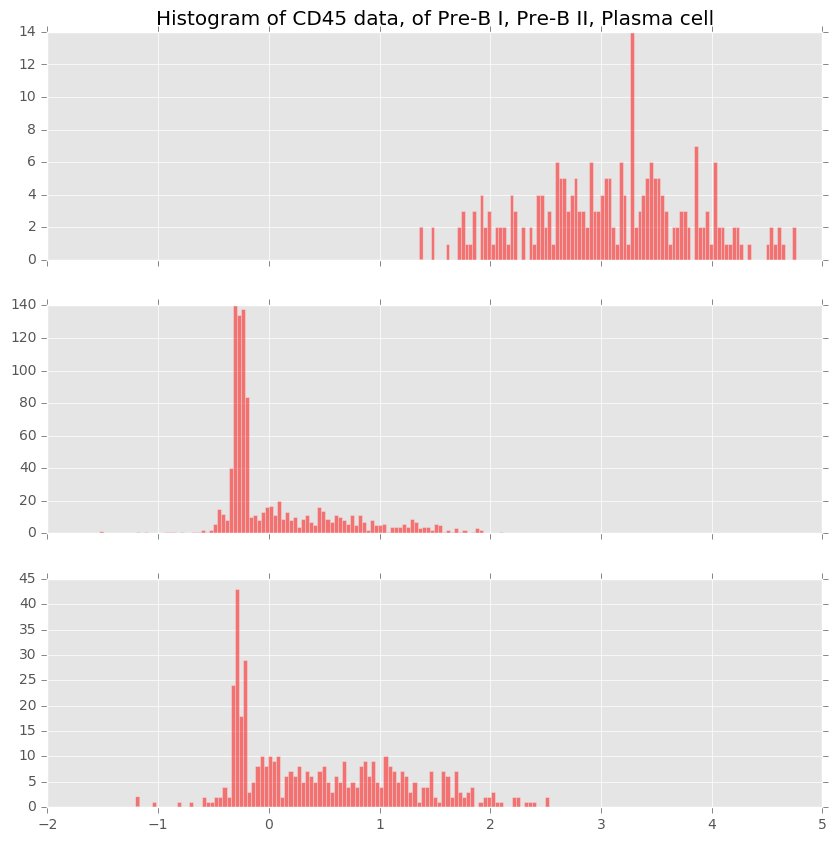

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex='col', sharey='row',figsize = (10,10))
ax1.hist(PreB1_cells['CD34'], color = 'r', alpha = 0.5, bins = 100);
ax1.set_title('Histogram of CD45 data, of Pre-B I, Pre-B II, Plasma cell');
ax2.hist(PreB2_cells['CD34'], color = 'r', alpha = 0.5, bins = 100);
ax3.hist(Plasma_cells['CD34'], color = 'r', alpha = 0.5, bins = 100);

In [ ]:
def count_structues(table):
    